# Learning Goals

By the end of this tutorial you will: <br>
* Learn to search a survey for observations of a known target.
* Understand how to use source-clustering to search for a dwarf galaxy. 
* Be able to plot an observation.
* Apply the methods of searching for a known target to discover a new target in other surveys.


# Introduction

Ultra-faint dwarf (UFD) galaxies are a subset of dwarf galaxies that are classified by having one hundred thousand to a few hundred thousand stars, making them the faintest galaxies in the universe. They differ from globular clusters in that they have a significant amount of dark matter which extends beyond the visible stellar matter. Because of their high concentration of dark matter, astronomers believe there could be unique insights into the early universe in UFD's. All UFD's that have been discovered are ancient systems that are believed to have formed only a few million years after the Big Bang.  
 
 
In this notebook, we will reproduce the methodology of finding a known UDF from the literature using data from the Pan-STARRS (PS1) catalog. We will be using the paper "Milky Way Satellite Census. I. The Observational Selection Function for Milky Way Satellites in DES Y3 and Pan-STARRS DR1" by Drlica-Wagner et al. 2020 to choose our target. 


# Imports

The following cell holds the imported packages. These packages are necessary for running the rest of the cells in this notebook. A description of each import is as follows:

* numpy to handle array functions
* pandas to handle date conversions
* fits from astropy.io for accessing FITS files
* Table from astropy.table for creating tidy tables of the data
* matplotlib.pyplot for plotting data
* Mast and Observations from astroquery.mast for querying data and observations from the MAST archive

**TO UPDATE DISCRIPTIONS**

In [149]:
%matplotlib inline
import sys
import re
import numpy as np
import matplotlib.pyplot as plt
import json
import requests
import http.client as httplib 
from urllib.parse import quote as urlencode
from urllib.request import urlretrieve
from astropy.io import fits
from astropy.table import Table
from astroquery.mast import Mast
from astroquery.mast import Observations
from astroquery.mast import Catalogs
from astropy.io import ascii
from astropy.table import Table

# Main Content

## Choosing a Target

Using Table 2 and Table 4 from Drlica-Wagner et al. 2020, we can choose a UFD that has PS1 data to search for. We will choose the UFD with the brightest magneitude that has been confirmed using PS1: **Leo I**. 

Table 2 lists the Right Ascention, Declination, and distance of **Leo I** which we will use to search the database.

### Gather necessary parameters 

Table 2 lists the Right Ascention, Declination, and distance of **Leo I** which we will use to search the database. Addiontioanally we will need the API url in order to search PS1 for this target. 

In [90]:
ra = "152.1146" #[deg]
dec = "12.3059" #[deg]
dist = "254" #[kpc]
radius = "0.1" #[deg] = 6 arcminutes

baseurl="https://catalogs.mast.stsci.edu/api/v0.1/panstarrs/" #this is the base url for querying the API
release = "dr1/" #you can also look at dr2 if you want
obj = "mean" #we will look at the mean data objects, dr1 only has mean and stack, dr2 has more options
condition = "nDetections.gte=1"
form = "csv"

## Searching Pan-STARRS

The Panoramic Survey Telescope & Rapid Response System (Pan-STARRS) is a wide-field imaging facility developed at the University of Hawaii's Institute for Astronomy. We are going to be using the MAST API for PS1 to gather our data

### Build API URL and Get Data

In [91]:
#now build the url to get the data from using the parameters we gathered
url = baseurl+release+obj+"?ra="+ra+"&dec="+dec+"&radius="+radius+"&"+condition+"&format="+form
print(url)

#Request data from the API
results = requests.get(url)
results = results.text

#Make a table from the results
tab = ascii.read(results)
tab

https://catalogs.mast.stsci.edu/api/v0.1/panstarrs/dr1/mean?ra=152.1146&dec=12.3059&radius=0.1&nDetections.gte=1&format=csv


objName,objAltName1,objAltName2,objAltName3,objID,uniquePspsOBid,ippObjID,surveyID,htmID,zoneID,tessID,projectionID,skyCellID,randomID,batchID,dvoRegionID,processingVersion,objInfoFlag,qualityFlag,raStack,decStack,raStackErr,decStackErr,raMean,decMean,raMeanErr,decMeanErr,epochMean,posMeanChisq,cx,cy,cz,lambda,beta,l,b,nStackObjectRows,nStackDetections,nDetections,ng,nr,ni,nz,ny,gQfPerfect,gMeanPSFMag,gMeanPSFMagErr,gMeanPSFMagStd,gMeanPSFMagNpt,gMeanPSFMagMin,gMeanPSFMagMax,gMeanKronMag,gMeanKronMagErr,gMeanKronMagStd,gMeanKronMagNpt,gMeanApMag,gMeanApMagErr,gMeanApMagStd,gMeanApMagNpt,gFlags,rQfPerfect,rMeanPSFMag,rMeanPSFMagErr,rMeanPSFMagStd,rMeanPSFMagNpt,rMeanPSFMagMin,rMeanPSFMagMax,rMeanKronMag,rMeanKronMagErr,rMeanKronMagStd,rMeanKronMagNpt,rMeanApMag,rMeanApMagErr,rMeanApMagStd,rMeanApMagNpt,rFlags,iQfPerfect,iMeanPSFMag,iMeanPSFMagErr,iMeanPSFMagStd,iMeanPSFMagNpt,iMeanPSFMagMin,iMeanPSFMagMax,iMeanKronMag,iMeanKronMagErr,iMeanKronMagStd,iMeanKronMagNpt,iMeanApMag,iMeanApMagErr,iMeanApMagStd,iMeanApMagNpt,iFlags,zQfPerfect,zMeanPSFMag,zMeanPSFMagErr,zMeanPSFMagStd,zMeanPSFMagNpt,zMeanPSFMagMin,zMeanPSFMagMax,zMeanKronMag,zMeanKronMagErr,zMeanKronMagStd,zMeanKronMagNpt,zMeanApMag,zMeanApMagErr,zMeanApMagStd,zMeanApMagNpt,zFlags,yQfPerfect,yMeanPSFMag,yMeanPSFMagErr,yMeanPSFMagStd,yMeanPSFMagNpt,yMeanPSFMagMin,yMeanPSFMagMax,yMeanKronMag,yMeanKronMagErr,yMeanKronMagStd,yMeanKronMagNpt,yMeanApMag,yMeanApMagErr,yMeanApMagStd,yMeanApMagNpt,yFlags,distance
str26,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,float64
PSO J100812.378+121437.020,-999,-999,-999,122691520515712829,1050851000038379,99982543721962,0,15576002199561,12269,1,1627,3,0.905097870067784,1050851,23279,3,444674048,53,152.05137966,12.24367575,0.0010000000474974513,0.0010000000474974513,152.05156455,12.24360176,0.1360200047492981,0.1360200047492981,56641.63505787,-999.0,-0.8632773195429764,0.45801659641815,0.21206854308979314,149.69409311563422,0.7093891798623613,226.0256632419873,49.02661363112472,-999,1,1,0,0,0,1,0,-999.0,-999.0,-999.0,-999.0,0,-999.0,-999.0,-999.0,-999.0,-999.0,0,-999.0,-999.0,-999.0,0,16416,-999.0,-999.0,-999.0,-999.0,0,-999.0,-999.0,-999.0,-999.0,-999.0,0,-999.0,-999.0,-999.0,0,16416,-999.0,-999.0,-999.0,-999.0,0,-999.0,-999.0,-999.0,-999.0,-999.0,0,-999.0,-999.0,-999.0,0,114720,0.12285300344228745,20.91900062561035,0.13518600165843964,-999.0,1,20.91900062561035,20.91900062561035,20.561599731445312,0.21158599853515625,-999.0,1,20.50629997253418,0.13518600165843964,-999.0,1,16777752,-999.0,-999.0,-999.0,-999.0,0,-999.0,-999.0,-999.0,-999.0,-999.0,0,-999.0,-999.0,-999.0,0,16416,0.08760675049051964
PSO J100812.342+121431.595,-999,-999,-999,122691520514011071,1050851000038310,99982543721893,0,15576002200439,12269,1,1627,3,0.81823076663374,1050851,23279,3,444751872,53,152.05142599,12.24210979,0.0010000000474974513,0.0010000000474974513,152.05147137,12.2421103,0.05778000131249428,0.05778000131249428,55940.16552083,3.543299913406372,-0.8632814508684135,0.4580205874677323,0.2120431042081784,149.69453143364967,0.7079618549051301,226.02761501080818,49.02584456742544,-999,5,5,0,4,0,1,0,-999.0,-999.0,-999.0,-999.0,0

## Plot Color-Magnitude Diagram (CMD) of Target

Color-Magnitude Diagrams (CMD) are a common way astronomers visualize the photometric parameters of a stellar system. Where the stars of a system fall on a CMD can tell you things like the age of that system and therefore, what types of stars it is composed of. 

### Gather arrays for plotting
A CMD consists of the magnitudes in one filter (y-axis) vs the difference between the magnitudes in that filter and the magnitudes in another filter (x-axis). For this example we will plot the magntidues of **Leo I** in G vs the magnitude of **Leo I** in G-R. In order to plot a CMD we will need a couple arrays:

* Magnitudes in the G filter
* Magnitudes in the R filter

In [117]:
g_mag = tab["gMeanApMag"] #mean aperture magntiude in G filter
r_mag = tab["rMeanApMag"] #mean aperture magntiude in R filter

# ind_g = np.where(g_mag != -999)
# ind_r = np.where(r_mag != -999)
# g_mag = g_mag[ind_r]
# r_mag = r_mag[ind_r]

#convert to numpy arrays for easy plotting
g_mag = np.array(g_mag)
r_mag = np.array(r_mag)

#get the difference between the filters 
g_r = np.subtract(g_mag,r_mag)


### Plot CMD in g - r

Text(0, 0.5, 'g')

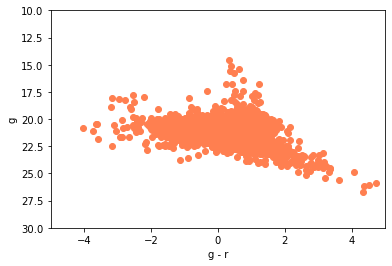

In [118]:
plt.scatter(g_r, g_mag, c = "coral")
plt.xlim(-5,5)
plt.ylim(30,10)
plt.xlabel("g - r")
plt.ylabel("g")

In [119]:
i_mag = tab["iMeanApMag"] #mean aperture magntiude in I filter
r_mag = tab["rMeanApMag"] #mean aperture magntiude in R filter

#convert to numpy arrays for easy plotting
i_mag = np.array(i_mag)
r_mag = np.array(r_mag)

#get the difference between the filters 
r_i = np.subtract(r_mag,i_mag)

### Plot CMD in r - i

Text(0, 0.5, 'i')

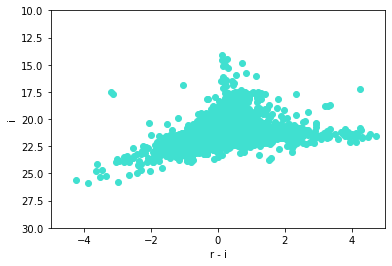

In [120]:
plt.scatter(r_i, i_mag, c = "turquoise")
plt.xlim(-5,5)
plt.ylim(30,10)
plt.xlabel("r - i")
plt.ylabel("i")

## Plot Field of View (FOV) of Target

### Build the url to the fits file of the region for our target


In [168]:
size = "240" #extracted image size in pixels (0.25 arcsec/pixel)
form = "fits" #file format of the file we would like

color = "red" #you can change this, red is typically the i filter

#get the url to the PS1 images
images_url = "https://ps1images.stsci.edu/cgi-bin/ps1filenames.py?ra="+ra+"&dec="+dec+"&filters="+filters
#read the images data into a table
img_table = Table.read(images_url, format='ascii')
print(len(img_table))

#get the first filename from the list of images
file = img_table['filename'][2]

#build the url to the fits file
fits_url = "https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?ra="+ra+"&dec="+dec+"&size="+size+"&format="+form+"&"+color+"="+file

print(fits_url)

5
https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?ra=152.1146&dec=12.3059&size=240&format=fits&red=/rings.v3.skycell/1627/003/rings.v3.skycell.1627.003.stk.r.unconv.fits


### Open the fits file and plot the image

Here we will plot the field of view containing our UFD, **Leo I**. Remember, it is *Ultra*-Faint!

Text(0.5, 1.0, 'Leo I - PS1 i')

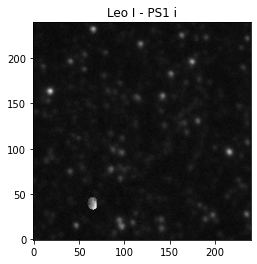

In [169]:
#open the fits file and get the data
fh = fits.open(fits_url)
fits_img = fh[0].data

# replace NaN values with zero for display
fits_img[np.isnan(fits_img)] = 0.0

#show the fits image
plt.imshow(fits_img,cmap="gray",origin="lower")
plt.title("Leo I - PS1 i")

# Exercises

# Additional Resources

This is the paper we referenced for the methods of this notebook: https://arxiv.org/abs/1912.03302 

Discriptions for the PS1 MeanObjectView table fields can be found here: https://outerspace.stsci.edu/display/PANSTARRS/PS1+MeanObjectView+table+fields



# About this Notebook

**Author:** Emma Lieb <br>
**Last Updated:** Jul 25th 2022

# Citations

* [Citation for `astropy`](https://www.astropy.org/acknowledging.html)